In [34]:
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image, ImageOps
%matplotlib inline

In [2]:
# choose model
inceptionv3 = models.inception_v3(pretrained=True) #download and load pretrained inceptionv3 model
inceptionv3.eval();

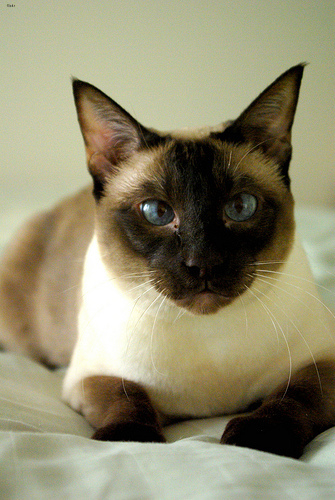

In [3]:
#load data and labels

img1 = Image.open("peppers.jpg")
img2 = Image.open("yorkshire_terrier_2.jpg")
img3 = Image.open("Siamese_25.jpg")
img4 = Image.open("pug_1.jpg")

labels_link = "https://savan77.github.io/blog/labels.json"    
labels_json = requests.get(labels_link).json()
labels = {int(idx):label for idx, label in labels_json.items()}
img3

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
preprocess = transforms.Compose([
                transforms.Resize((299,299)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])



In [5]:
def img_process(img):
    
    image_tensor = preprocess(img) #preprocess an i
    image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W
    img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable
    output = inceptionv3.forward(img_variable)
    label_idx = torch.max(output.data, 1)[1][0]   #get an index(class number) of a largest element
    x_pred = labels[int(label_idx)]
    output_probs = F.softmax(output, dim=1)
    x_pred_prob =  np.round((torch.max(output_probs.data, 1)[0][0]) * 100,4)
    
    history={"image_tensor":image_tensor,"img_variable":img_variable,"x_pred":x_pred,"x_pred_prob":x_pred_prob}
    return history

history1=img_process(img1)
history2=img_process(img2)
history3=img_process(img3)
history4=img_process(img4)
print(history2['x_pred'],history2['x_pred_prob'])

Yorkshire terrier tensor(89.9576)


In [6]:
def visualize(x, x_adv, x_grad, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).detach().numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(7,5))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=10)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=10)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=10)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+", size=10, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=10, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=10, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=10, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()
    

In [7]:
#img_variable = Variable(image_tensor, requires_grad=True)


In [8]:
#img_variable.data = image_tensor   #in previous method we assigned it to the adversarial img

In [9]:
def fitmodel(num_steps,epsilon,lr,lamda,image_tensor,y_target):
    Loss=[]
    img_variable = Variable(image_tensor, requires_grad=True)    
    for i in range(num_steps):
        zero_gradients(img_variable)
        #compute loss and grad
        output = inceptionv3.forward(img_variable)
        loss = torch.nn.CrossEntropyLoss()
        loss_cal = loss(output, y_target)
        loss_cal.backward()
        x_grad = torch.sign(img_variable.grad.data)+lamda*0.5

        #optimization  
        adv_temp = img_variable.data - lr*x_grad    
        total_grad = adv_temp - image_tensor        #noise
        total_grad = torch.clamp(total_grad, -epsilon, epsilon)
        x_adv = image_tensor + total_grad

        #compute updated loss function
        output1 = inceptionv3.forward(img_variable)    
        newloss=loss(output1, y_target).data+0.5*lamda*total_grad.max()
        Loss.append(newloss)
        #Loss.append(np.round(float(Loss1[i].data),4))
        print('loss:',newloss)
        img_variable.data = x_adv
    
    return Loss, x_adv, total_grad

In [10]:
history1=img_process(img1)
history2=img_process(img2)
history3=img_process(img3)
history4=img_process(img4)

y1_target = Variable(torch.LongTensor([812]), requires_grad=False)
y2_target = Variable(torch.LongTensor([812]), requires_grad=False)
y3_target = Variable(torch.LongTensor([812]), requires_grad=False)    
y4_target = Variable(torch.LongTensor([812]), requires_grad=False)



In [11]:
#epsilon = 0.25
#num_steps = 20
#alpha = 0.015
#lamda=1e-3
#Loss, img_variable=fitmodel(num_steps,epsilon,alpha,lamda,img_variable)
Loss1, x_adv1,total_grad1=fitmodel(20,0.25,0.015,1e-2,history1["img_variable"],y1_target)


loss: tensor(9.4685, grad_fn=<AddBackward0>)
loss: tensor(7.5802, grad_fn=<AddBackward0>)
loss: tensor(6.3299, grad_fn=<AddBackward0>)
loss: tensor(5.4715, grad_fn=<AddBackward0>)
loss: tensor(4.5771, grad_fn=<AddBackward0>)
loss: tensor(1.1102, grad_fn=<AddBackward0>)
loss: tensor(0.0146, grad_fn=<AddBackward0>)
loss: tensor(0.0123, grad_fn=<AddBackward0>)
loss: tensor(0.0013, grad_fn=<AddBackward0>)
loss: tensor(0.0008, grad_fn=<AddBackward0>)
loss: tensor(0.0008, grad_fn=<AddBackward0>)
loss: tensor(0.0009, grad_fn=<AddBackward0>)
loss: tensor(0.0577, grad_fn=<AddBackward0>)
loss: tensor(0.0011, grad_fn=<AddBackward0>)
loss: tensor(0.0011, grad_fn=<AddBackward0>)
loss: tensor(0.0012, grad_fn=<AddBackward0>)
loss: tensor(0.0836, grad_fn=<AddBackward0>)
loss: tensor(0.0012, grad_fn=<AddBackward0>)
loss: tensor(0.0013, grad_fn=<AddBackward0>)
loss: tensor(0.0012, grad_fn=<AddBackward0>)


In [12]:
Loss2, x_adv2,total_grad2=fitmodel(12,0.25,0.01,1e-2,history2["img_variable"],y2_target)

loss: tensor(10.1162, grad_fn=<AddBackward0>)
loss: tensor(8.0032, grad_fn=<AddBackward0>)
loss: tensor(7.1327, grad_fn=<AddBackward0>)
loss: tensor(6.5529, grad_fn=<AddBackward0>)
loss: tensor(6.1101, grad_fn=<AddBackward0>)
loss: tensor(5.4442, grad_fn=<AddBackward0>)
loss: tensor(4.4815, grad_fn=<AddBackward0>)
loss: tensor(2.9359, grad_fn=<AddBackward0>)
loss: tensor(0.6216, grad_fn=<AddBackward0>)
loss: tensor(0.2823, grad_fn=<AddBackward0>)
loss: tensor(0.0432, grad_fn=<AddBackward0>)
loss: tensor(0.0058, grad_fn=<AddBackward0>)


In [13]:
Loss3, x_adv3,total_grad3=fitmodel(15,0.25,0.015,1e-2,history3["img_variable"],y3_target)

loss: tensor(10.5946, grad_fn=<AddBackward0>)
loss: tensor(7.7940, grad_fn=<AddBackward0>)
loss: tensor(6.9528, grad_fn=<AddBackward0>)
loss: tensor(6.2870, grad_fn=<AddBackward0>)
loss: tensor(5.7270, grad_fn=<AddBackward0>)
loss: tensor(5.2963, grad_fn=<AddBackward0>)
loss: tensor(5.1857, grad_fn=<AddBackward0>)
loss: tensor(4.8811, grad_fn=<AddBackward0>)
loss: tensor(4.2137, grad_fn=<AddBackward0>)
loss: tensor(2.9082, grad_fn=<AddBackward0>)
loss: tensor(1.8328, grad_fn=<AddBackward0>)
loss: tensor(0.0366, grad_fn=<AddBackward0>)
loss: tensor(0.0202, grad_fn=<AddBackward0>)
loss: tensor(0.0051, grad_fn=<AddBackward0>)
loss: tensor(0.0012, grad_fn=<AddBackward0>)


In [19]:
Loss4, x_adv4,total_grad4=fitmodel(20,0.25,0.015,1e-2,history4["img_variable"],y4_target)

loss: tensor(9.8716, grad_fn=<AddBackward0>)
loss: tensor(7.3720, grad_fn=<AddBackward0>)
loss: tensor(6.4252, grad_fn=<AddBackward0>)
loss: tensor(5.7045, grad_fn=<AddBackward0>)
loss: tensor(4.9168, grad_fn=<AddBackward0>)
loss: tensor(3.8587, grad_fn=<AddBackward0>)
loss: tensor(0.0697, grad_fn=<AddBackward0>)
loss: tensor(0.0012, grad_fn=<AddBackward0>)
loss: tensor(0.0012, grad_fn=<AddBackward0>)
loss: tensor(0.0008, grad_fn=<AddBackward0>)
loss: tensor(0.0008, grad_fn=<AddBackward0>)
loss: tensor(0.3544, grad_fn=<AddBackward0>)
loss: tensor(0.0010, grad_fn=<AddBackward0>)
loss: tensor(0.0010, grad_fn=<AddBackward0>)
loss: tensor(0.0011, grad_fn=<AddBackward0>)
loss: tensor(0.4878, grad_fn=<AddBackward0>)
loss: tensor(0.0013, grad_fn=<AddBackward0>)
loss: tensor(0.0012, grad_fn=<AddBackward0>)
loss: tensor(0.0020, grad_fn=<AddBackward0>)
loss: tensor(0.0013, grad_fn=<AddBackward0>)


In [20]:
def post_process(x_adv):
    output_adv = inceptionv3.forward(x_adv)
    x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]
    output_adv_probs = F.softmax(output_adv, dim=1)
    x_adv_pred_prob =  np.round((torch.max(output_adv_probs.data, 1)[0][0]) * 100,4)    
    return  x_adv_pred,x_adv_pred_prob

In [22]:
x_adv1_pred,x_adv1_pred_prob=post_process(x_adv1)
x_adv2_pred,x_adv2_pred_prob=post_process(x_adv2)
x_adv3_pred,x_adv3_pred_prob=post_process(x_adv3)
x_adv4_pred,x_adv4_pred_prob=post_process(x_adv4)
x_adv4_pred,x_adv4_pred_prob

('space shuttle', tensor(100.))

In [17]:
#x_adv2_pred,x_adv2_pred_prob=post_process(x_adv2)
#x_adv3_pred,x_adv3_pred_prob=post_process(x_adv3)
#x_adv4_pred,x_adv4_pred_prob=post_process(x_adv4)

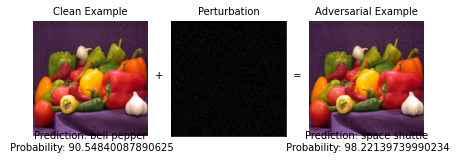

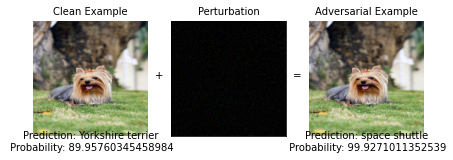

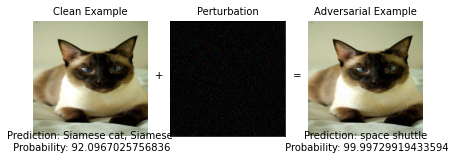

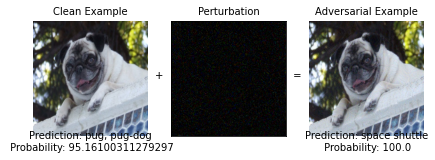

In [23]:

visualize(history1["image_tensor"], x_adv1.data, total_grad1, 
          history1["x_pred"],x_adv1_pred, history1["x_pred_prob"],  x_adv1_pred_prob)

visualize(history2["image_tensor"], x_adv2.data, total_grad2, 
          history2["x_pred"],x_adv2_pred, history2["x_pred_prob"],  x_adv2_pred_prob)

visualize(history3["image_tensor"], x_adv3.data, total_grad3, 
          history3["x_pred"],x_adv3_pred, history3["x_pred_prob"],  x_adv3_pred_prob)

visualize(history4["image_tensor"], x_adv4.data, total_grad4, 
          history4["x_pred"],x_adv4_pred, history4["x_pred_prob"],  x_adv4_pred_prob)

In [24]:
x_adv1.shape

torch.Size([1, 3, 299, 299])

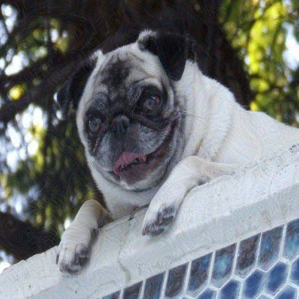

In [100]:
def save_adv_img(x_adv,name):
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()#reverse of normalization op
    x_adv= np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    img = Image.fromarray((x_adv * 255).astype(np.uint8))
    img.save(name)
    
save_adv_img(x_adv1,'myadv1.png')
save_adv_img(x_adv2,'myadv2.png')
save_adv_img(x_adv3,'myadv3.png')
save_adv_img(x_adv4,'myadv4.png')
imload = Image.open('myadv4.png')
imload 

In [95]:
history_adv1=img_process(imload)
print(history_adv1['x_pred'],history_adv1['x_pred_prob'])

space shuttle tensor(99.9967)


In [109]:
## Part 2  Robustness
from PIL import Image, ImageOps

#flip
im_flip = ImageOps.flip(imload) 
history_adv1=img_process(im_flip)
print(history_adv1['x_pred'],history_adv1['x_pred_prob'])

#crop the center of the image
width, height = imload.size   #(299,299)
W=0.8*width
H=0.8*height
left = (width - W)/2
top = (height - H)/2
right = (width + W)/2
bottom = (height + H)/2
im_crop= imload.crop((left, top, right, bottom)) #(239,239)

history_adv1=img_process(im_crop)
print(history_adv1['x_pred'],history_adv1['x_pred_prob'])

#rotate
im_rotate=imload.rotate(30)

history_adv1=img_process(im_rotate)
print(history_adv1['x_pred'],history_adv1['x_pred_prob'])


# grey
im_grey = imload.convert('L')
K=np.array(im_grey)
Knew=np.stack([K,K,K]).transpose(1,2,0)
im_grey_3 = Image.fromarray(Knew)
im_grey_3.show()
#history_adv1=img_process(im_grey_3 )
#print(history_adv1['x_pred'],history_adv1['x_pred_prob'])


pug, pug-dog tensor(19.7803)
pug, pug-dog tensor(46.9371)
pug, pug-dog tensor(95.2166)


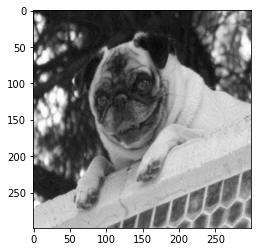

In [112]:
def img_tsfm (imgload):   
    im_flip = ImageOps.flip(imload)   #flip   
    width, height = imload.size   #crop
    W=0.8*width
    H=0.8*height
    left = (width - W)/2
    top = (height - H)/2
    right = (width + W)/2
    bottom = (height + H)/2
    im_crop= imload.crop((left, top, right, bottom)) #(239,239)    
    im_rotate=imload.rotate(30)    #rotate   
    
    im_grey = imload.convert('L')    # grey
    K=np.array(im_grey)
    Knew=np.stack([K,K,K]).transpose(1,2,0)
    im_grey_3 = Image.fromarray(Knew)
    return im_flip, im_crop,im_rotate,im_grey_3 

im_flip, im_crop,im_rotate,im_grey_3 =img_tsfm (imload )
#plt.imshow(im_grey_3)

In [57]:
def img_pred(img_tsfm):
    history_adv=img_process(img_tsfm)
    pred=history_adv['x_pred']
    prob=history_adv['x_pred_prob']
    return pred, prob

In [113]:
def show_tsfm(im_flip, im_crop,im_rotate,im_grey_3,flip_pred,flip_prob,
                     crop_pred,crop_prob,rotate_pred,rotate_prob,
                     grey_3_pred,grey_3_prob):
    
    figure, ax = plt.subplots(1,4, figsize=(10,8))
    ax[0].imshow(im_flip)
    ax[0].set_title('Flip Image', fontsize=10)
    
    ax[1].imshow(im_crop)
    ax[1].set_title('Crop Image', fontsize=10)
    
    ax[2].imshow(im_rotate)
    ax[2].set_title('Rotate Image', fontsize=10)
    
    ax[3].imshow(im_grey_3)
    ax[3].set_title('Grayscale Image', fontsize=10)
    
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    
    ax[0].text(0.5,-0.13, "Pred: {}\n Prob: {}".format(flip_pred, flip_prob), size=10, ha="center", 
         transform=ax[0].transAxes)
    ax[1].text(0.5,-0.13, "Pred: {}\n Prob: {}".format(crop_pred, crop_prob), size=10, ha="center", 
         transform=ax[1].transAxes)
    ax[2].text(0.5,-0.13, "Pred: {}\n Prob: {}".format(rotate_pred, rotate_prob), size=10, ha="center", 
         transform=ax[2].transAxes)
    ax[3].text(0.5,-0.13, "Pred: {}\n Prob: {}".format(grey_3_pred, grey_3_prob), size=10, ha="center", 
         transform=ax[3].transAxes)
    
    plt.show()

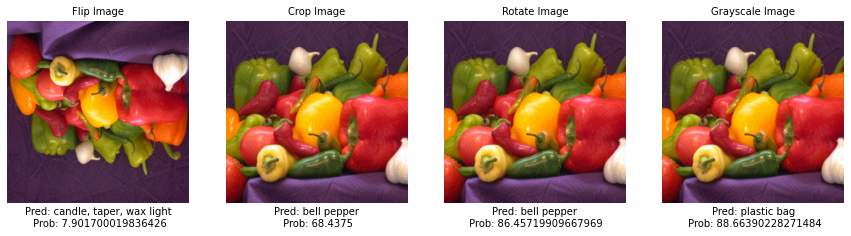

tensor(7.9017)

In [81]:
imgload1 = Image.open('myadv1.png')
im_flip1, im_crop1,im_rotate1,im_grey_31= img_tsfm (imgload1)
flip1_pred,flip1_prob=img_pred(im_flip1)
crop1_pred,crop1_prob=img_pred(im_crop1)
rotate1_pred,rotate1_prob=img_pred(im_rotate1)
grey1_pred,grey1_prob=img_pred(im_grey_31)

show_tsfm(im_flip1, im_crop1,im_rotate1,im_grey_31,flip1_pred,flip1_prob,
                     crop1_pred,crop1_prob,rotate1_pred,rotate1_prob,
                     grey1_pred,grey1_prob)


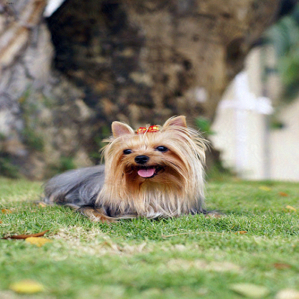

In [85]:
imgload2 = Image.open('myadv2.png')
imgload2

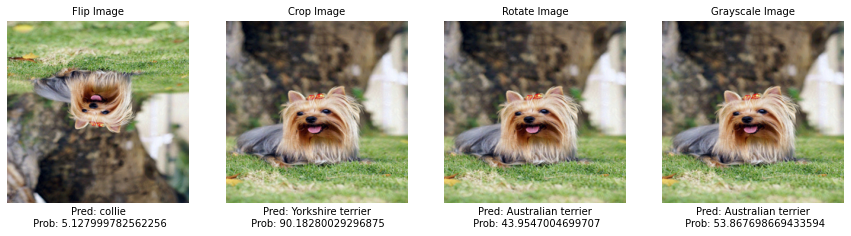

In [86]:
im_flip2, im_crop2,im_rotate2,im_grey_32= img_tsfm (imgload2)
flip2_pred,flip2_prob=img_pred(im_flip2)
crop2_pred,crop2_prob=img_pred(im_crop2)
rotate2_pred,rotate2_prob=img_pred(im_rotate2)
grey2_pred,grey2_prob=img_pred(im_grey_32)

show_tsfm(im_flip2, im_crop2,im_rotate2,im_grey_32,flip2_pred,flip2_prob,
                     crop2_pred,crop2_prob,rotate2_pred,rotate2_prob,
                     grey2_pred,grey2_prob)

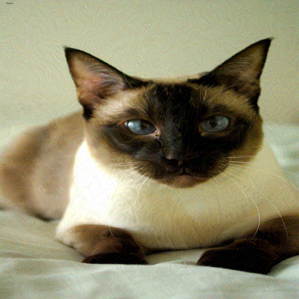

In [96]:
imgload3 = Image.open('myadv3.png')
imgload3

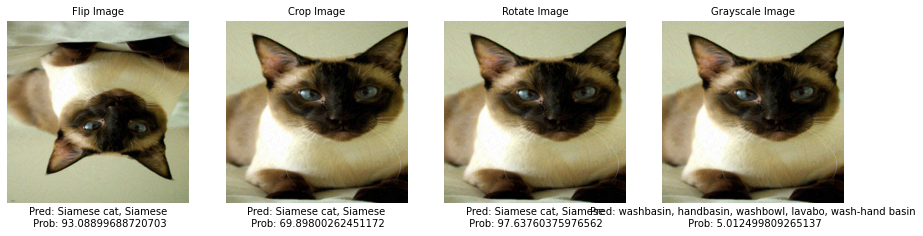

In [98]:
im_flip3, im_crop3,im_rotate3,im_grey_33= img_tsfm(imgload3)
flip3_pred,flip3_prob=img_pred(im_flip3)
crop3_pred,crop3_prob=img_pred(im_crop3)
rotate3_pred,rotate3_prob=img_pred(im_rotate3)
grey3_pred,grey3_prob=img_pred(im_grey_33)

show_tsfm(im_flip3, im_crop3,im_rotate3,im_grey_33,flip3_pred,flip3_prob,
                     crop3_pred,crop3_prob,rotate3_pred,rotate3_prob,
                     grey3_pred,grey3_prob)


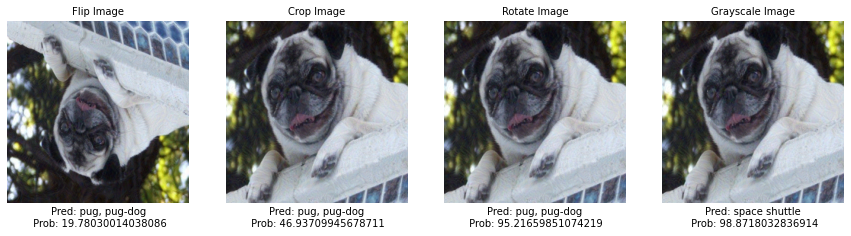

In [102]:
im_flip4, im_crop4,im_rotate4,im_grey_34= img_tsfm(imgload4)
flip4_pred,flip4_prob=img_pred(im_flip4)
crop4_pred,crop4_prob=img_pred(im_crop4)
rotate4_pred,rotate4_prob=img_pred(im_rotate4)
grey4_pred,grey4_prob=img_pred(im_grey_34)

show_tsfm(im_flip4, im_crop4,im_rotate4,im_grey_34,flip4_pred,flip4_prob,
                     crop4_pred,crop4_prob,rotate4_pred,rotate4_prob,
                     grey4_pred,grey4_prob)

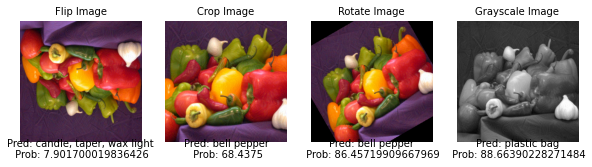

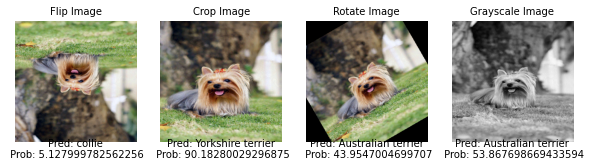

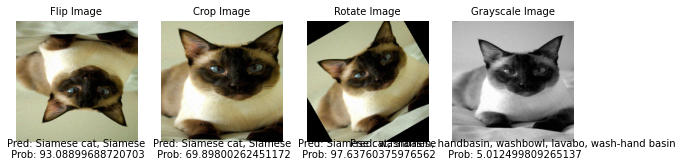

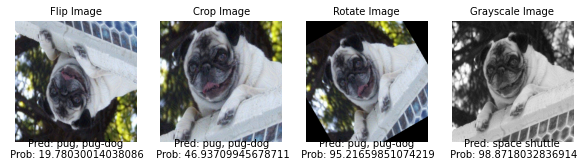

In [114]:
show_tsfm(im_flip1, im_crop1,im_rotate1,im_grey_31,flip1_pred,flip1_prob,
                     crop1_pred,crop1_prob,rotate1_pred,rotate1_prob,
                     grey1_pred,grey1_prob)

show_tsfm(im_flip2, im_crop2,im_rotate2,im_grey_32,flip2_pred,flip2_prob,
                     crop2_pred,crop2_prob,rotate2_pred,rotate2_prob,
                     grey2_pred,grey2_prob)

show_tsfm(im_flip3, im_crop3,im_rotate3,im_grey_33,flip3_pred,flip3_prob,
                     crop3_pred,crop3_prob,rotate3_pred,rotate3_prob,
                     grey3_pred,grey3_prob)

show_tsfm(im_flip4, im_crop4,im_rotate4,im_grey_34,flip4_pred,flip4_prob,
                     crop4_pred,crop4_prob,rotate4_pred,rotate4_prob,
                     grey4_pred,grey4_prob)

In [ ]:
dict={'myadv1.png','myadv2.png','myadv3.png','myadv4.png'}
for i in range(4)
    imgload = Image.open(dict[i])
    
    im_flip, im_crop,im_rotate,im_grey= img_tsfm (imgload)
    flip_pred,flip_prob=img_pred(im_flip)
    crop_pred,crop_prob=img_pred(im_crop)
    rotate_pred,rotate_prob=img_pred(im_rotate)
    grey_pred,grey_prob=img_pred(im_grey_3)

    show_tsfm(im_flip, im_crop,im_rotate,im_grey_3,flip_pred,flip_prob,
                         crop_pred,crop_prob,rotate_pred,rotate_prob,
                         grey_pred,grey_prob)
